In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from datetime import datetime

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import get_weather_data


In [31]:
weatherData = get_weather_data.WeatherData("2022-01-01", str(datetime.today()), dallas_flag="Dallas")

df = weatherData.build_obs_df()

df = df.fillna(0)

pd.to_datetime(df["time"])

0      2022-01-01 00:00:00
1      2022-01-01 01:00:00
2      2022-01-01 02:00:00
3      2022-01-01 03:00:00
4      2022-01-01 04:00:00
               ...        
8268   2022-12-11 12:00:00
8269   2022-12-11 13:00:00
8270   2022-12-11 14:00:00
8271   2022-12-11 15:00:00
8272   2022-12-11 16:00:00
Name: time, Length: 8273, dtype: datetime64[ns]

In [74]:
def featureForecast(feature):

    y = df.set_index("time")[feature]
    y = y.values.reshape(-1, 1)

    # scale the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(y)
    y = scaler.transform(y)

    # generate the input and output sequences
    n_lookback = 120  # length of input sequences (lookback period)
    n_forecast = 120  # length of output sequences (forecast period)

    X = []
    Y = []

    for i in range(n_lookback, len(y) - n_forecast + 1):
        X.append(y[i - n_lookback: i])
        Y.append(y[i: i + n_forecast])

    X = np.array(X)
    Y = np.array(Y)

    # fit the model
    model = keras.Sequential()
    model.add(keras.layers.LSTM(units = 50, return_sequences = True, input_shape = (n_lookback, 1)))
    model.add(keras.layers.Dropout(rate = 0.2))
    model.add(keras.layers.LSTM(units = 50, return_sequences = True))
    model.add(keras.layers.Dropout(rate = 0.2))
    model.add(keras.layers.LSTM(units = 50, return_sequences = True))
    model.add(keras.layers.Dropout(rate = 0.2))
    model.add(keras.layers.LSTM(units = 50, return_sequences = False))
    model.add(keras.layers.Dropout(rate = 0.2))
    model.add(keras.layers.Dense(n_forecast))

    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X, Y, epochs=15, batch_size=32)

    # generate the forecasts
    X_ = y[- n_lookback:]  # last available input sequence
    X_ = X_.reshape(1, n_lookback, 1)

    Y_ = model.predict(X_).reshape(-1, 1)
    Y_ = scaler.inverse_transform(Y_)

    # organize the results in a data frame
    df_past = df[[feature]].reset_index()
    df_past.rename(columns={'index': 'time'}, inplace=True)
    df_past['time'] = pd.to_datetime(df['time'])
    df_past['Forecast'] = np.nan    
    df_past['Forecast'].iloc[-1] = df_past[feature].iloc[-1]
    

    df_future = pd.DataFrame(columns=['time', feature, 'Forecast'])
    df_future['time'] = pd.date_range(start=df_past['time'].iloc[-1] + pd.Timedelta(hours = 1), freq="H", periods = n_forecast)
    df_future['Forecast'] = Y_.flatten()
    df_future[feature] = np.nan

    results = df_past.append(df_future).set_index('time')

    # plot the results
    results.plot(title=feature)

    df_future[feature] = df_future["Forecast"]
    df_future = df_future.drop(columns="Forecast")
    return df_future

Epoch 1/15
252/252 [==============================] - 23s 81ms/step - loss: 0.0478
Epoch 2/15
252/252 [==============================] - 23s 91ms/step - loss: 0.0220
Epoch 3/15
252/252 [==============================] - 23s 92ms/step - loss: 0.0198
Epoch 4/15
252/252 [==============================] - 24s 95ms/step - loss: 0.0187
Epoch 5/15
252/252 [==============================] - 24s 95ms/step - loss: 0.0179
Epoch 6/15
252/252 [==============================] - 24s 95ms/step - loss: 0.0166
Epoch 7/15
252/252 [==============================] - 24s 95ms/step - loss: 0.0143
Epoch 8/15
252/252 [==============================] - 24s 95ms/step - loss: 0.0132
Epoch 9/15
252/252 [==============================] - 20s 78ms/step - loss: 0.0126
Epoch 10/15
252/252 [==============================] - 14s 56ms/step - loss: 0.0122
Epoch 11/15
252/252 [==============================] - 16s 65ms/step - loss: 0.0118
Epoch 12/15
252/252 [==============================] - 16s 64ms/step - loss: 0.0114
E

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/15
252/252 [==============================] - 27s 95ms/step - loss: 0.0739
Epoch 2/15
252/252 [==============================] - 24s 95ms/step - loss: 0.0321
Epoch 3/15
252/252 [==============================] - 24s 95ms/step - loss: 0.0297
Epoch 4/15
252/252 [==============================] - 24s 94ms/step - loss: 0.0279
Epoch 5/15
252/252 [==============================] - 24s 95ms/step - loss: 0.0267
Epoch 6/15
252/252 [==============================] - 24s 95ms/step - loss: 0.0262
Epoch 7/15
252/252 [==============================] - 24s 95ms/step - loss: 0.0257
Epoch 8/15
252/252 [==============================] - 24s 95ms/step - loss: 0.0251
Epoch 9/15
252/252 [==============================] - 24s 95ms/step - loss: 0.0245
Epoch 10/15
252/252 [==============================] - 24s 95ms/step - loss: 0.0244
Epoch 11/15
252/252 [==============================] - 24s 95ms/step - loss: 0.0238
Epoch 12/15
252/252 [==============================] - 24s 95ms/step - loss: 0.0240
E

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/15
252/252 [==============================] - 27s 96ms/step - loss: 0.0733
Epoch 2/15
252/252 [==============================] - 24s 95ms/step - loss: 0.0490
Epoch 3/15
252/252 [==============================] - 24s 95ms/step - loss: 0.0387
Epoch 4/15
252/252 [==============================] - 24s 94ms/step - loss: 0.0360
Epoch 5/15
252/252 [==============================] - 24s 94ms/step - loss: 0.0347
Epoch 6/15
252/252 [==============================] - 24s 94ms/step - loss: 0.0336
Epoch 7/15
252/252 [==============================] - 24s 94ms/step - loss: 0.0326
Epoch 8/15
252/252 [==============================] - 24s 94ms/step - loss: 0.0316
Epoch 9/15
252/252 [==============================] - 24s 94ms/step - loss: 0.0311
Epoch 10/15
252/252 [==============================] - 24s 94ms/step - loss: 0.0298
Epoch 11/15
252/252 [==============================] - 24s 94ms/step - loss: 0.0288
Epoch 12/15
252/252 [==============================] - 24s 94ms/step - loss: 0.0279
E

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/15
252/252 [==============================] - 26s 94ms/step - loss: 2.9182e-04
Epoch 2/15
252/252 [==============================] - 24s 94ms/step - loss: 2.9117e-04
Epoch 3/15
252/252 [==============================] - 24s 94ms/step - loss: 2.9113e-04
Epoch 4/15
252/252 [==============================] - 24s 94ms/step - loss: 2.9107e-04
Epoch 5/15
252/252 [==============================] - 24s 94ms/step - loss: 2.9099e-04
Epoch 6/15
252/252 [==============================] - 24s 94ms/step - loss: 2.9075e-04
Epoch 7/15
252/252 [==============================] - 24s 94ms/step - loss: 2.9080e-04
Epoch 8/15
252/252 [==============================] - 24s 94ms/step - loss: 2.9049e-04
Epoch 9/15
252/252 [==============================] - 24s 94ms/step - loss: 2.9046e-04
Epoch 10/15
252/252 [==============================] - 24s 94ms/step - loss: 2.9032e-04
Epoch 11/15
252/252 [==============================] - 24s 94ms/step - loss: 2.9036e-04
Epoch 12/15
252/252 [====================

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/15
252/252 [==============================] - 30s 97ms/step - loss: 0.0884
Epoch 2/15
252/252 [==============================] - 24s 96ms/step - loss: 0.0719
Epoch 3/15
252/252 [==============================] - 24s 96ms/step - loss: 0.0700
Epoch 4/15
252/252 [==============================] - 24s 97ms/step - loss: 0.0703
Epoch 5/15
252/252 [==============================] - 24s 97ms/step - loss: 0.0689
Epoch 6/15
252/252 [==============================] - 24s 97ms/step - loss: 0.0680
Epoch 7/15
252/252 [==============================] - 24s 96ms/step - loss: 0.0674
Epoch 8/15
252/252 [==============================] - 24s 97ms/step - loss: 0.0673
Epoch 9/15
252/252 [==============================] - 24s 97ms/step - loss: 0.0668
Epoch 10/15
252/252 [==============================] - 24s 97ms/step - loss: 0.0666
Epoch 11/15
252/252 [==============================] - 24s 97ms/step - loss: 0.0662
Epoch 12/15
252/252 [==============================] - 24s 97ms/step - loss: 0.0660
E

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/15
252/252 [==============================] - 27s 95ms/step - loss: 0.0293
Epoch 2/15
252/252 [==============================] - 24s 95ms/step - loss: 0.0232
Epoch 3/15
252/252 [==============================] - 24s 94ms/step - loss: 0.0227
Epoch 4/15
252/252 [==============================] - 24s 95ms/step - loss: 0.0220
Epoch 5/15
252/252 [==============================] - 24s 95ms/step - loss: 0.0215
Epoch 6/15
252/252 [==============================] - 24s 95ms/step - loss: 0.0206
Epoch 7/15
252/252 [==============================] - 24s 95ms/step - loss: 0.0201
Epoch 8/15
252/252 [==============================] - 24s 95ms/step - loss: 0.0204
Epoch 9/15
252/252 [==============================] - 24s 95ms/step - loss: 0.0206
Epoch 10/15
252/252 [==============================] - 24s 95ms/step - loss: 0.0195
Epoch 11/15
252/252 [==============================] - 24s 95ms/step - loss: 0.0194
Epoch 12/15
252/252 [==============================] - 24s 95ms/step - loss: 0.0188
E

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/15
252/252 [==============================] - 27s 95ms/step - loss: 0.0394
Epoch 2/15
252/252 [==============================] - 24s 95ms/step - loss: 0.0226
Epoch 3/15
252/252 [==============================] - 24s 95ms/step - loss: 0.0199
Epoch 4/15
252/252 [==============================] - 24s 95ms/step - loss: 0.0184
Epoch 5/15
252/252 [==============================] - 24s 95ms/step - loss: 0.0177
Epoch 6/15
252/252 [==============================] - 24s 95ms/step - loss: 0.0173
Epoch 7/15
252/252 [==============================] - 24s 95ms/step - loss: 0.0169
Epoch 8/15
252/252 [==============================] - 24s 95ms/step - loss: 0.0163
Epoch 9/15
252/252 [==============================] - 24s 95ms/step - loss: 0.0185
Epoch 10/15
252/252 [==============================] - 24s 95ms/step - loss: 0.0166
Epoch 11/15
252/252 [==============================] - 24s 95ms/step - loss: 0.0158
Epoch 12/15
252/252 [==============================] - 24s 95ms/step - loss: 0.0171
E

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


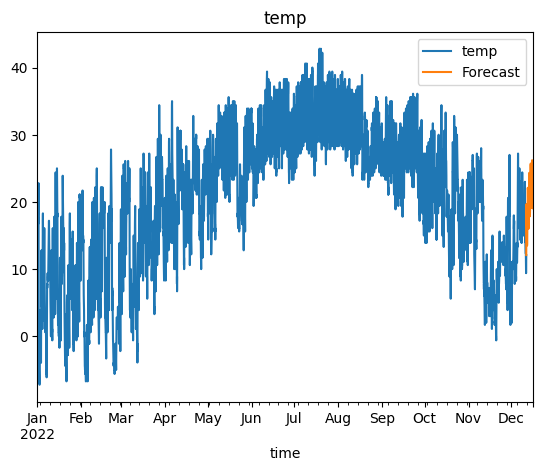

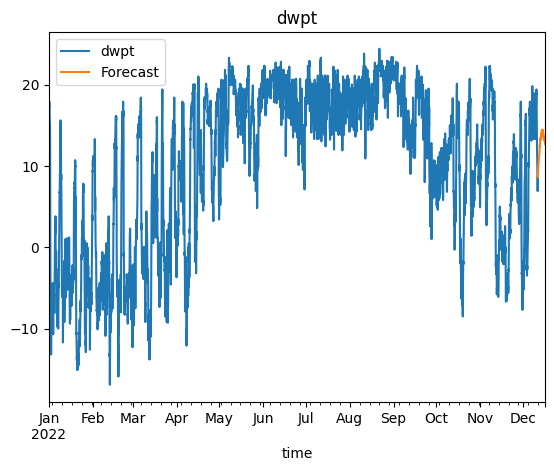

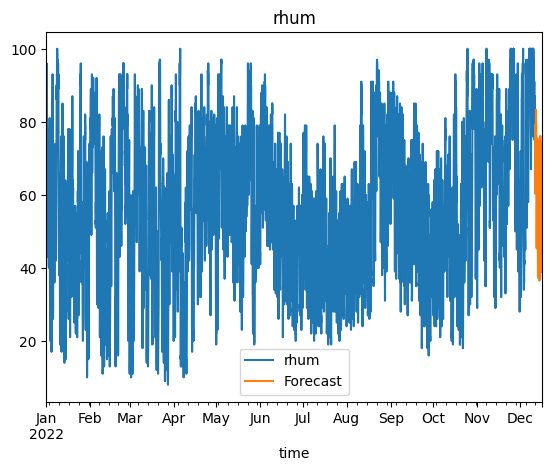

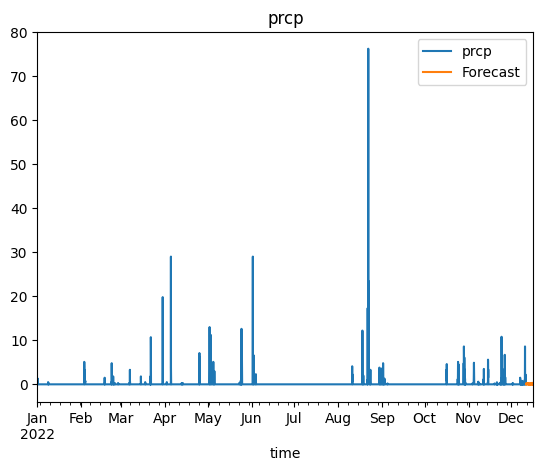

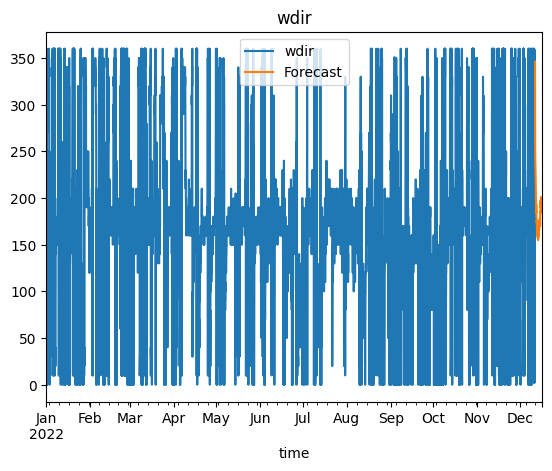

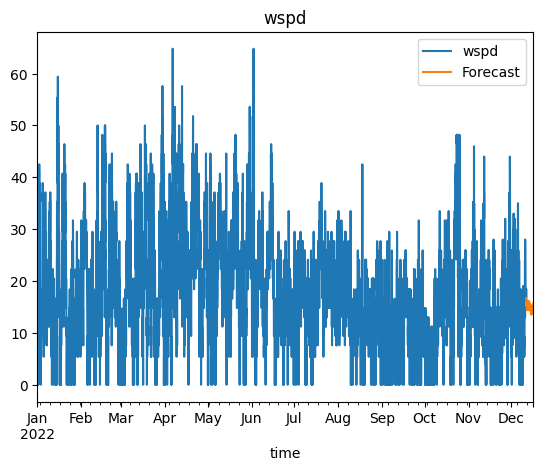

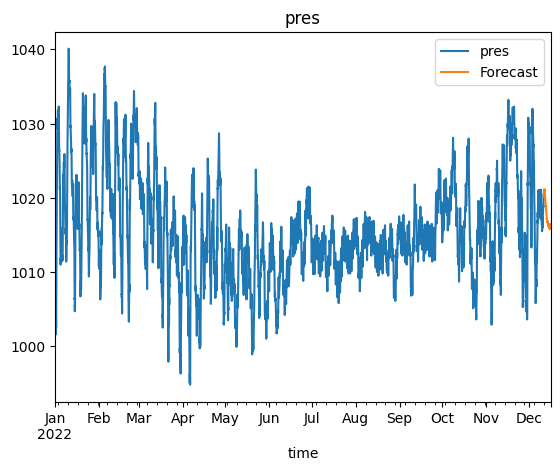

In [75]:
#select columns to forecast
features = ["temp", "dwpt", "rhum", "prcp", "wdir", "wspd", "pres"]

forecasts = pd.DataFrame()

#analyze selected columns and add results to dictionary
for feature in features:
    if forecasts.empty:
        forecasts = featureForecast(feature)
        continue
    forecasts = forecasts.merge(featureForecast(feature), on='time')


In [76]:
forecasts.to_csv("forecast.csv")